# Hierarchical SHAP

This notebook contains code and examples for a hierarchical implementation of Shapley coefficients evaluation for images, with a fixed size of features per layer.



In [71]:
%matplotlib inline

#IMPORTS
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

#IMPORT UTILS
!wget https://raw.githubusercontent.com/JacopoTeneggi/Interpretability/master/Utils/utils.py -P local_modules -nc
import local_modules.utils as Utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



## Load the model

This pre-trained model detects the presence of a cross in the image. If the cross is detected, the image is labeled with a ```1```, with a ```0``` otherwhise.

In [72]:
#LOAD PRE-TRAINED-NETWORK
model = Utils.Net()
model.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 
# model.eval() deactivates the dropout layer in the network
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')
train_data_dir = "train_data_dir"
data.extractall(train_data_dir)
data.close()
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(train_data_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0)
background.detach()

# LOAD EXAMPLE IMAGES
ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data2", transform = transf)
example_batch_size = 2
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)

# LABEL = 0
image0 = images[0]
label0 = labels[0]
input0 = image0.view(-1, 3, 100, 120)
output0 = model(input0)
print(output0)

# LABEL = 1
image1 = images[1]
label1 = labels[1]
input1 = image1.view(-1, 3, 100, 120)
output1 = model(input1)
print(output1)

tensor([[ 11.1314, -13.0076]], grad_fn=<AddmmBackward>)
tensor([[-79.0918,  88.0700]], grad_fn=<AddmmBackward>)


## Hierarchical SHAP implementation

This implementation relies on two classes:

1. ```HierarchicalSHAPExplainer```

2. ```HierarchicalSHAPNode```

### HierarchicalSHAPNode

It is the class that takes care of the actual evaluation of Shapley coefficients. It explores relevant features recursively so that we only get the deepest, most relevant features as an output. We do not save any intermediate nodes to save memory and reduce complexity.

### HierarchicalSHAPExplainer

It is a wrapper class that initialize the environment for the nodes. The ```explain()``` method simply calls the evaluation on the root node (i.e. the entire imagine).

In [73]:
class HierarchicalSHAPNode:
  """
  Represents the single feature
  """

  def __init__(self, explainer, depth, M, features, masks, path = None, score = None):
    self.explainer = explainer
    self.depth = depth
    self.M = M
    self.features = features
    self.masks = masks
    self.path = path
    self.score = score

  def computeShap(self, feature, predictions):
    feature_index = np.where(feature == 1)
    subset_indices = np.where(self.masks[:, feature_index[0][0]] == 0)
    subset = self.masks[subset_indices]
    added_subset = [np.add(sub, feature) for sub in subset] 
    deltas = np.array(list(zip(added_subset, subset)))
    diffs = [1/comb(self.M - 1, np.sum(b)) * (predictions[self.mask2str(a)] - predictions[self.mask2str(b)]) for a, b in deltas]
    phi = np.sum(diffs) / self.M
    return phi.detach().numpy()

  def mask2path(self, mask):
    if self.path is None:
      return [mask]
    else:
      return np.concatenate((self.path, mask))
  
  def mask2str(self, mask):
    return reduce(lambda a, b: str(a) + str(b), mask.astype(int)) 

  def str2mask(self, string):
    L = len(string) 
    mask = np.empty((L,))
    for i in range(L):
      mask[i] = int(string[i])
    return mask
  
  def pathMaskCoordinates(self, path, startRow = 0, endRow = 100, startColumn = 0, endColumn = 120):
    if path is not None:
      for layer in path:
        w = endColumn - startColumn
        h = endRow - startRow
        feature_index = np.where(layer == 1)[0]
        if feature_index == 0:
          endRow = startRow + h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 1:
          endRow = startRow + h / 2
          startColumn += w / 2
        elif feature_index == 2:
          startRow += h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 3:
          startRow += h / 2
          startColumn += w / 2
    return int(startRow), int(endRow), int(startColumn), int(endColumn)
  
  def maskInput(self, mask, rootInput, startRow, endRow, startColumn, endColumn, background):
    w = endColumn - startColumn
    h = endRow - startRow
    if (type(rootInput) == np.ndarray):
      maskedInput = rootInput.copy()
    else:
      maskedInput = rootInput.clone();
    maskIndices = np.where(mask == 0)[0]
    for index in maskIndices:
      maskStartRow = startRow
      maskEndRow = endRow
      maskStartColumn = startColumn
      maskEndColumn = endColumn
      # First quadrant
      if index == 0:
        maskEndRow = startRow + h / 2
        maskEndColumn = startColumn + w / 2
      # Second quadrant
      elif index == 1:
        maskEndRow = startRow + h / 2
        maskStartColumn += w / 2
      # Third quadrant
      elif index == 2:
        maskStartRow += h / 2
        maskEndColumn = startColumn + w / 2
      # Fourth quadrant
      elif index == 3:
        maskStartRow += h / 2
        maskStartColumn += w / 2
      maskStartRow = int(maskStartRow)
      maskEndRow = int(maskEndRow)
      maskStartColumn = int(maskStartColumn)
      maskEndColumn = int(maskEndColumn)
      maskedInput[:, maskStartRow:maskEndRow, maskStartColumn:maskEndColumn] = background[:, maskStartRow:maskEndRow, maskStartColumn:maskEndColumn]
    if (type(maskedInput) is not np.ndarray):
      maskedInput = maskedInput.view(-1, 3, 100, 120)
    return maskedInput

  def rootPathInput(self, path, input, background, w = 120, h = 100):
    startRow, endRow, startColumn, endColumn = self.pathMaskCoordinates(path, 0, h, 0, w)
    if (type(background) == np.ndarray):
      rootInput = background.copy()
    else:
      rootInput = background.clone()
    rootInput[:, startRow:endRow+1, startColumn:endColumn+1] = input[:, startRow:endRow+1, startColumn:endColumn+1]
    return rootInput, startRow, endRow, startColumn, endColumn
  
  def nodeScores(self, input, background, label, threshold, minW, minH):
    # 
    rootInput, startRow, endRow, startColumn, endColumn = self.rootPathInput(self.path, input, background)
    rootw = endColumn - startColumn
    rooth = endRow - startRow
    # Stop when it reaches the deepest layer and return current node
    if (rootw < 2*minW) or (rooth < 2*minH):
      return self
    # If not, go down another level and compute shap coefficients for features
    predictions = {self.mask2str(mask): self.explainer.model(self.maskInput(mask, rootInput, startRow, endRow, startColumn, endColumn, background))[:, label] for mask in self.masks}
    phis = {self.mask2str(feature): self.computeShap(feature, predictions) for feature in self.features}

    # Update number of computed features
    self.explainer.computed += self.M

    # Convert SHAP dictionary to lists -> TODO: evaluate wether SHAP dictionary is necessary
    values = np.fromiter(phis.values(), dtype=float)
    keys = list(phis.keys())

    # Identify relevant features
    if threshold is not None:
      relevantIndices = np.where(values > threshold)[0]
    else:
      relevantIndices = np.arange(self.M)

    # Update number of rejected features
    self.explainer.rejected += self.M - len(relevantIndices)

    # Initialize children and recursively compute SHAP values
    children = []
    for relevantIndex in relevantIndices:
      childPath = np.array([self.str2mask(keys[relevantIndex])])
      if self.path is not None:
        childPath = np.concatenate((self.path, childPath))
      child = HierarchicalSHAPNode(self.explainer, self.depth + 1, self.M, self.features, self.masks, path = childPath, score = values[relevantIndex])
      children.append(child.nodeScores(input, background, label, threshold, minW, minH))
    return children

class HierarchicalSHAPExplainer:

  def __init__(self, model, background, M):
    self.model = model
    self.computed = None
    self.rejected = None
    self.M = M
    self.MEAN = np.array([0.5, 0.5, 0.5])
    self.STD = np.array([0.5, 0.5, 0.5])
    self.input = input
    self.background = background
    self.masks = self.generateMasks() 
    self.features = np.identity(self.M, dtype=np.bool).reshape((self.M, self.M))

  def generateMasks(self):
    masks = np.ones((1,self.M), dtype=np.bool) # initialize masks array with all features on -> no need to compute permutations fro |S| = M
    for i in range(self.M):
      s = np.zeros(self.M, dtype=np.bool)
      s[0:i] = 1
      p = permutations(s)
      a = np.array(list(set(p)))
      masks = np.concatenate((masks, a))
    return masks

  def flatten(self, l):
    for el in l:
      if isinstance(el, list) and not isinstance(el, (str, bytes)):
        yield from self.flatten(el)
      else:
        yield el

  def addNodeMask(self, node, map):
    startRow, endRow, startColumn, endColumn = node.pathMaskCoordinates(node.path)
    nodeArea = (endRow + 1 - startRow) * (endColumn + 1 - startColumn)
    map[startRow:endRow+1, startColumn:endColumn+1] = node.score / nodeArea

  def explain(self, input, background, label = None, threshold = 0, minW = 2, minH = 2):
    self.computed = 0
    self.rejected = 0
    mainNode = HierarchicalSHAPNode(self, 0, 4, self.features, self.masks, score = 1)
    nodes = mainNode.nodeScores(input, background, label, threshold, minW, minH)
    flatnodes = list(self.flatten(nodes))
    saliency_map = np.zeros((100, 120))
    for node in flatnodes:
      self.addNodeMask(node, saliency_map)
    return saliency_map, flatnodes

# Initialize explainer
explainer = HierarchicalSHAPExplainer(model, background, 4)

## Explaining label ```1``` for image labeled ```1```

We are testing with the lowest threshold possible (```0```) and the smallest input allowed (```1x1```) to evaluate performance in a worst-case scenario.


STARTED EXPLAINING IMAGE 1 @ 1597144335.816186 s
Computed 1540 features out of 12000 pixels (12.83 %) in 13243.703 ms -> 8.600 ms per feature
Rejected 624 features (40.52 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

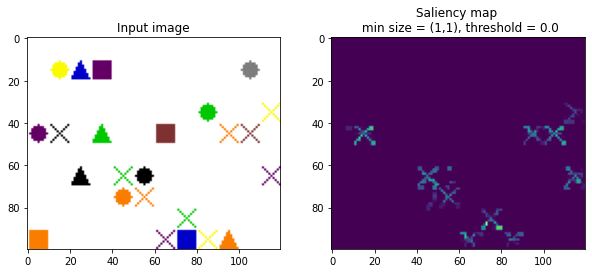

In [74]:
# EXPLAIN IMAGE 1 (with correct label)
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
computed = explainer.computed
rejected = explainer.rejected
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
im = Utils.input2image(image1, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Explaining label ```0``` for image labeled ```1```

STARTED EXPLAINING IMAGE 1 @ 1597144349.3940074 s
Computed 4 features out of 12000 pixels (0.03 %) in 46.597 ms -> 11.649 ms per feature
Rejected 4 features (100.00 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

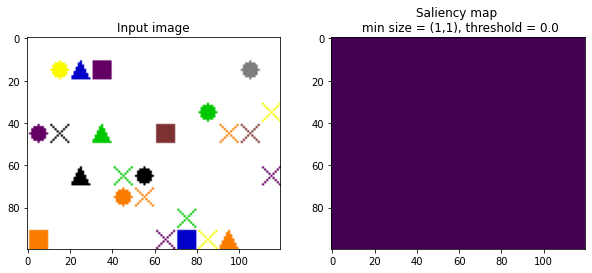

In [75]:
# EXPLAIN LABEL 0 FOR IMAGE 1
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image1, background, label = 0, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
computed = explainer.computed
rejected = explainer.rejected
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
im = Utils.input2image(image1, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Explaining label ```0``` for image labeled ```0```

We are testing with the lowest threshold possible (```0```) and the smallest input allowed (```1x1```) to evaluate performance in a worst-case scenario. 

STARTED EXPLAINING IMAGE @ 1597144349.7799864 s
Computed 4 features out of 12000 pixels (0.03 %) in 13833.483 ms -> 3458.371 ms per feature
Rejected 4 features (100.00 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

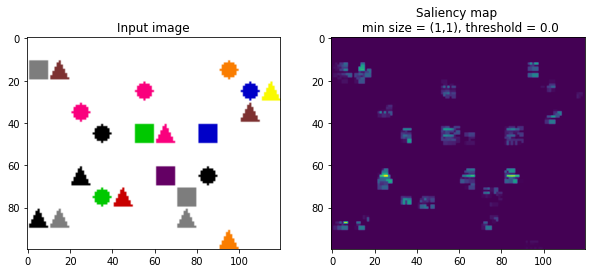

In [76]:
# EXPLAIN IMAGE 0
t0 = time.time()
print("STARTED EXPLAINING IMAGE @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image0, background, label = 0, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
im = Utils.input2image(image0, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Trying out different minimal feature sizes and thresholds

These examples explain label ```1``` for the positive (labeled as ```1```) image.


STARTED EXPLAINING IMAGE @ 1597144364.0153959 s
Computed 20 features out of 12000 pixels (0.17 %) in 172.194 ms -> 8.610 ms per feature
Rejected 9 features (45.00 %) @ threshold = 0.0 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597144364.189638 s
Computed 20 features out of 12000 pixels (0.17 %) in 169.244 ms -> 8.462 ms per feature
Rejected 10 features (50.00 %) @ threshold = 0.5 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597144364.360968 s
Computed 20 features out of 12000 pixels (0.17 %) in 166.697 ms -> 8.335 ms per feature
Rejected 10 features (50.00 %) @ threshold = 1.5 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597144364.5296173 s
Computed 20 features out of 12000 pixels (0.17 %) in 171.828 ms -> 8.591 ms per feature
Rejected 10 features (50.00 %) @ threshold = 2.0 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597144364.7033484 s
Computed 20 features out of 12000 pixels (0.17 %) in 165.415 ms -> 8.271 ms pe

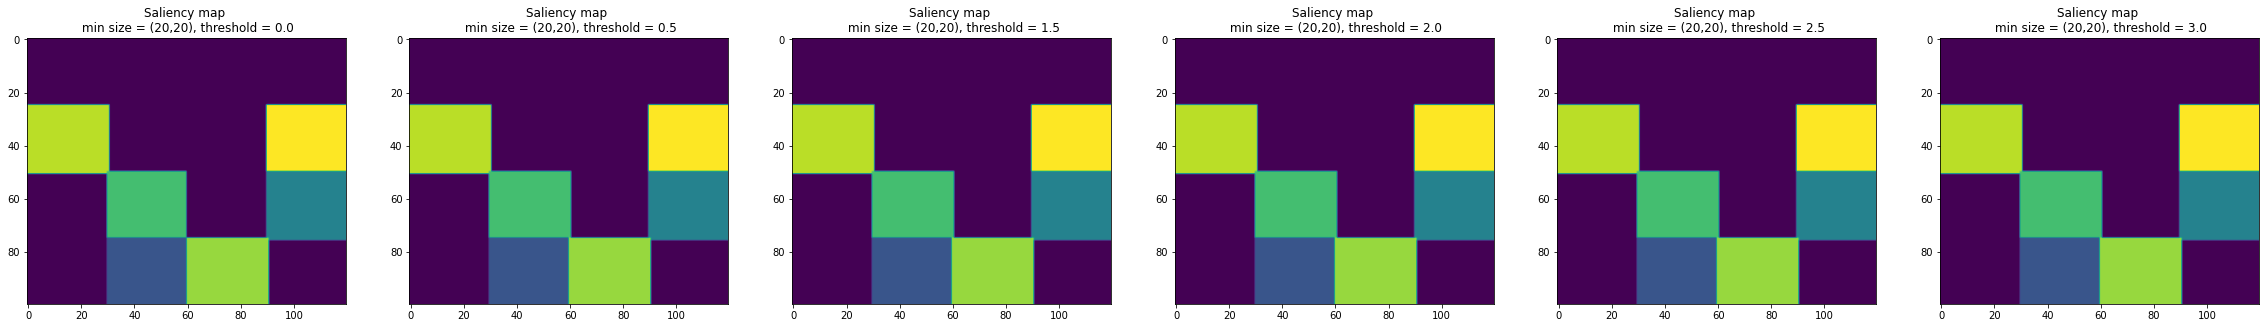

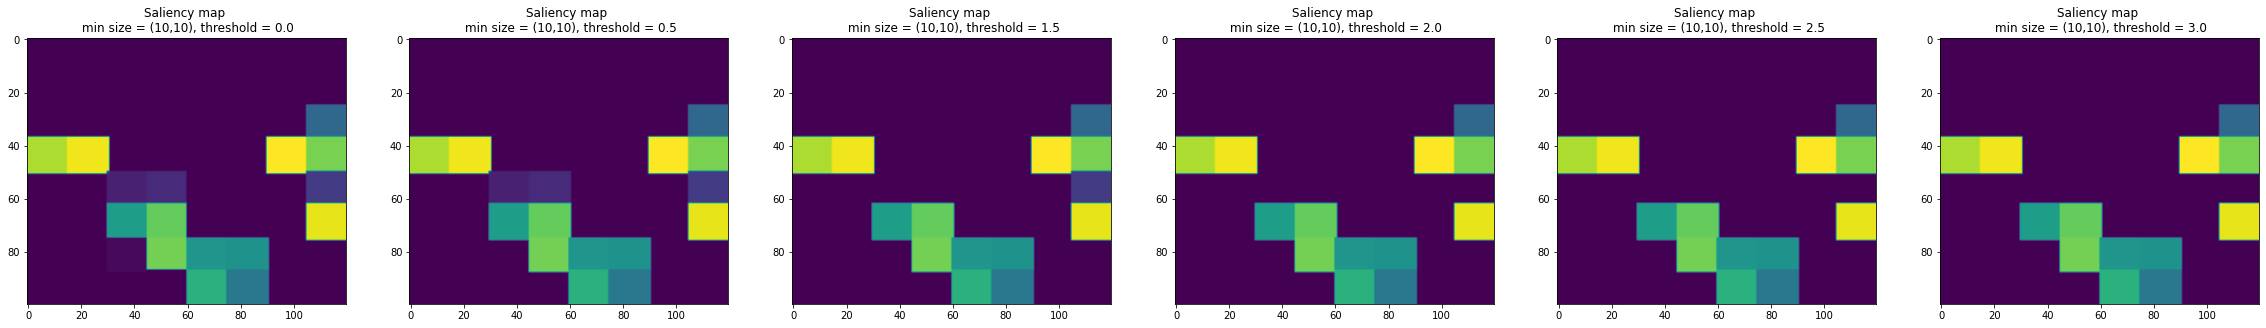

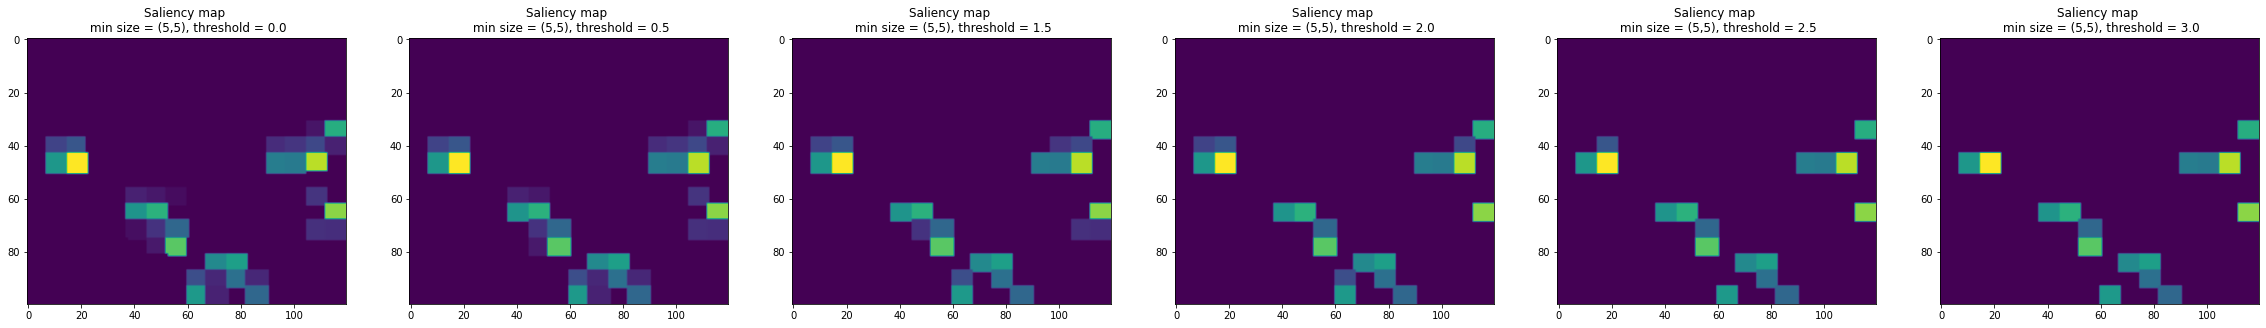

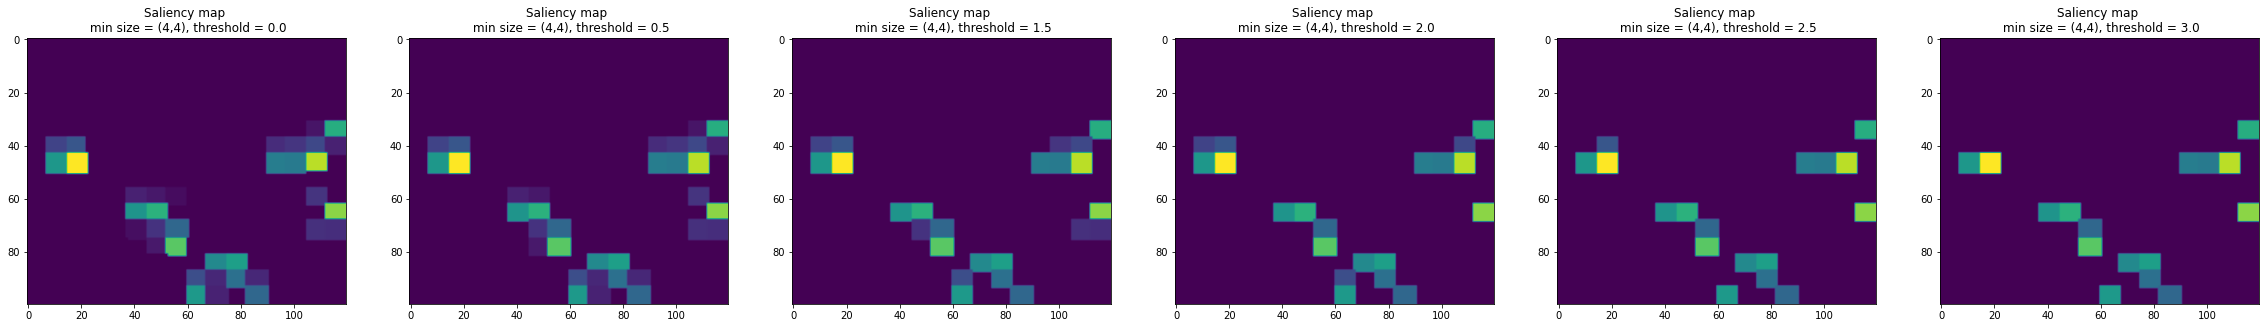

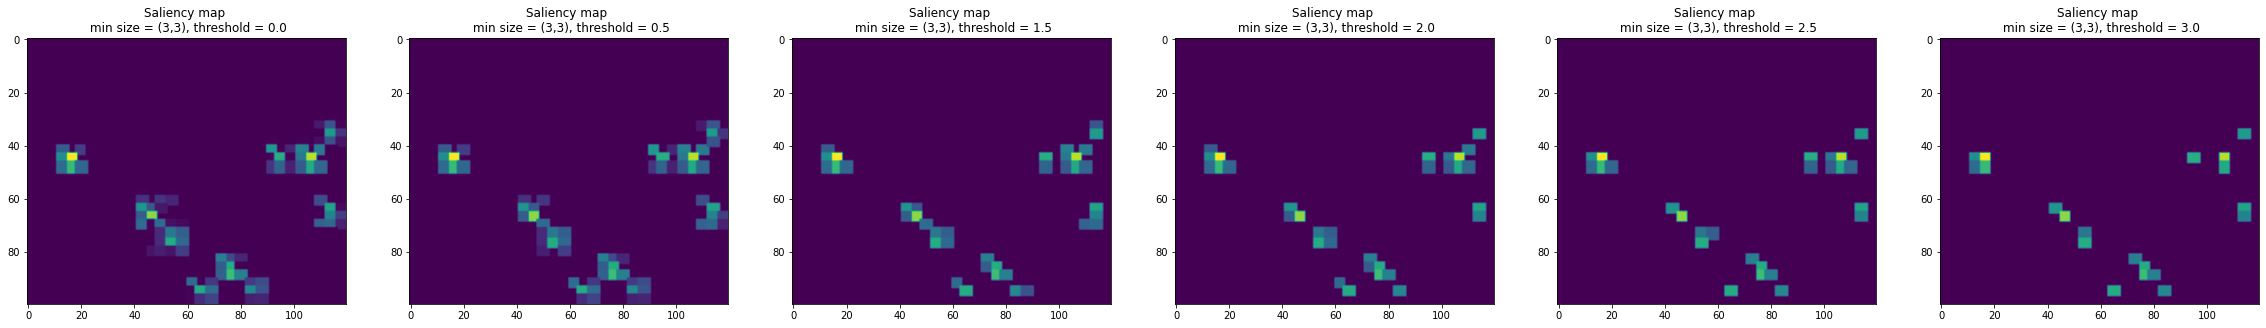

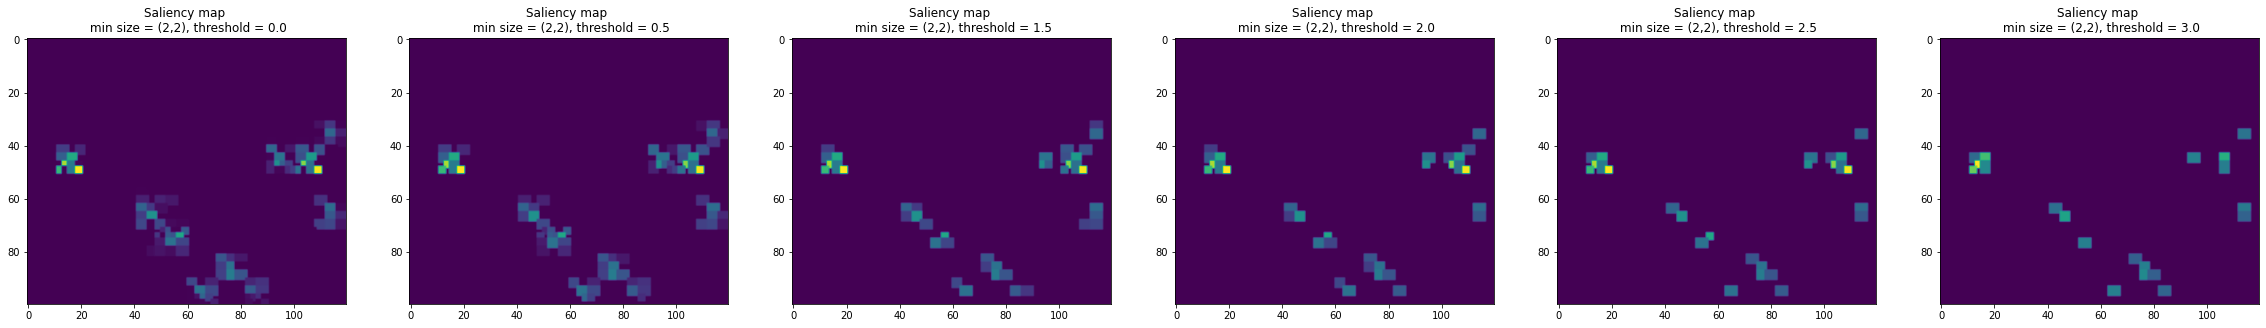

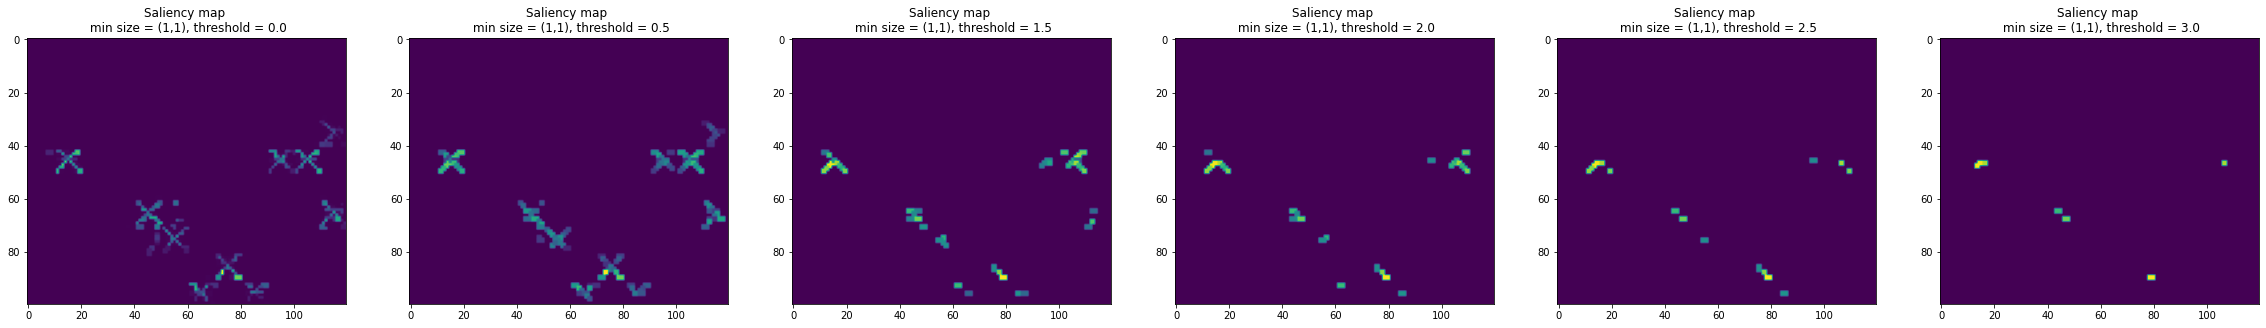

In [77]:
sizes = np.array([[20,20], [10,10], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1]])
thresholds = np.array([0., 0.5, 1.5, 2., 2.5, 3], dtype=float)

L1 = len(thresholds)
L2 = len(sizes)
X = np.zeros((L1, L2))
Y1 = np.zeros((L1, L2))
Y2 = np.zeros((L1, L2))
  
for i in np.arange(L2):
  size = sizes[i]
  minW = size[0]
  minH = size[1]
  fig = plt.figure(figsize=(40, 10))
  axes = fig.subplots(1, L1)
  for j in np.arange(L1):
    threshold = thresholds[j]
    t0 = time.time()
    print("\nSTARTED EXPLAINING IMAGE @", t0, "s")
    saliency_map, flatnodes = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
    tf = time.time()
    computed = explainer.computed
    rejected = explainer.rejected
    X[j, i] = minW
    Y1[j, i] = computed
    Y2[j, i] = rejected
    print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
    print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))
    axes[j].imshow(saliency_map)
    axes[j].set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))


### Plot number of features computed and rejection rate as a function of minimal feature size

We define the feature rejection rate as the percentage of computed features that are considered non-relevant.

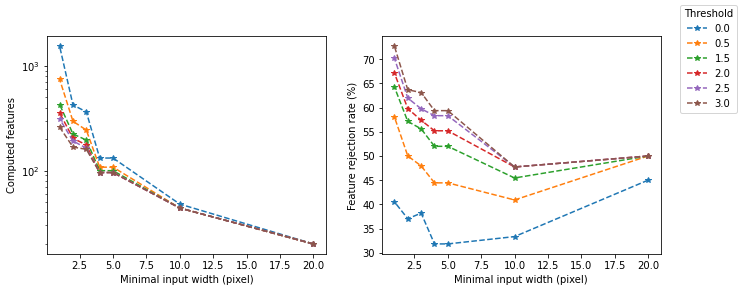

In [78]:
fig = plt.figure(figsize=(11, 4))
ax1, ax2 = fig.subplots(1, 2)

lines = []
labels = []

for i in np.arange(L1):
  l = ax1.plot(X[i, :], Y1[i, :], '*--')[0]
  ax2.plot(X[i, :], Y2[i, :]/Y1[i, :] * 100, '*--')
  lines.append(l)
  labels.append(thresholds[i])

ax1.set_xlabel('Minimal input width (pixel)')
ax1.set_ylabel('Computed features')
ax1.set_yscale('log')
ax2.set_xlabel('Minimal input width (pixel)')
ax2.set_ylabel('Feature rejection rate (%)')
fig.legend(lines, labels, title = "Threshold")
plt.show()

## Precision comparison with original ```shap``` library

Compare truth map with saliency maps evaluated by different SHAP approximations

In [97]:
#IMPORTS
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

#IMPORT UTILS
!wget https://raw.githubusercontent.com/JacopoTeneggi/Interpretability/master/Utils/utils.py -P local_modules -nc
import local_modules.utils as Utils

#INSTALL SHAP
!pip install shap
import shap

#LOAD PRE-TRAINED-NETWORK
model = Utils.Net()
model.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 
# model.eval() deactivates the dropout layer in the network
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')
train_data_dir = "train_data_dir"
data.extractall(train_data_dir)
data.close()
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(train_data_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0)
background.detach()

# LOAD EXAMPLE IMAGES FOLDER
ImF = ImageFolder(root = "/content/drive/My Drive/H-Shap", transform = transf)
example_batch_size = 2
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)
image = images[1]
label = labels[1]

# DEFINE EXAMPLE IMAGE
image = images[1]
label = labels[1]
# DEFINE INPUT
input = image.view(-1, 3, 100, 120)
input = input.detach()

# LOAD TRUTH MAP
truthMap = np.genfromtxt('/content/drive/My Drive/H-Shap/1/truth.csv', delimiter=',')

# GRADIENT EXPLAINER
gradexp = shap.GradientExplainer(model, X)
nsamples = 2000
t0 = time.time()
shapley_values, indexes = gradexp.shap_values(input, ranked_outputs=2, nsamples = nsamples)
tf = time.time()
gradPrediction = np.sum(shapley_values[0])
print('\nGradient Explainer:\nExecution completed in %.3f ms' % ((tf - t0)*1e3))

# H-SHAP EXPLAINER
explainer = HierarchicalSHAPExplainer(model, background, 4)

t0 = time.time()
print('\nHierarchical Explainer:')
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image, background, label = label, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
computed = explainer.computed
rejected = explainer.rejected
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.


Gradient Explainer:
Execution completed in 18536.157 ms

Hierarchical Explainer:
Computed 1272 features out of 12000 pixels (10.60 %) in 10831.658 ms -> 8.515 ms per feature
Rejected 615 features (48.35 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'H-explainer activation map (threshold = 0.00)\nActivation threshold = 0.00\nSensibility = 93.28% -- Specificity = 94.70%')

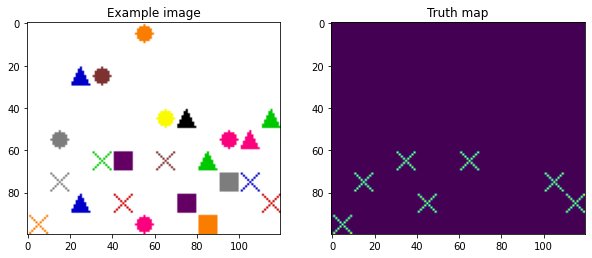

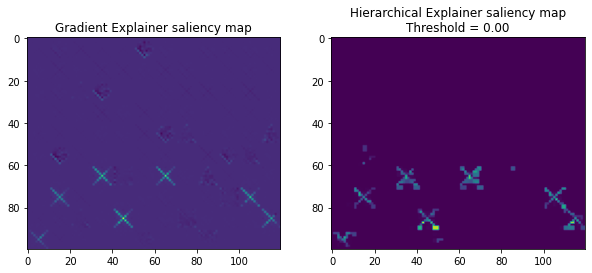

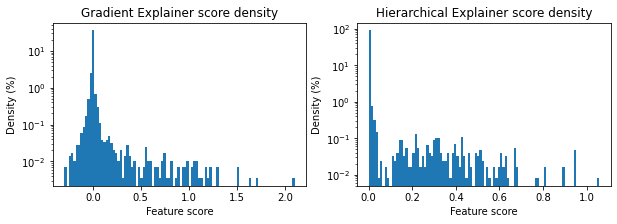

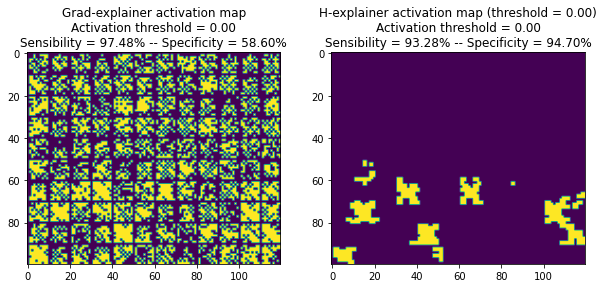

In [98]:
# EVALUATE SENSIBILITY/SPECIFICITY
gradientMap = np.sum(shapley_values[0][0], 0)
hierarchicalMap = saliency_map.copy()

# SHOW EXAMPLE IMAGE AND TRUTH MAP
fig = plt.figure(figsize=(10, 10))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(Utils.input2image(image, MEAN, STD))
ax1.set_title('Example image')
ax2.imshow(truthMap)
ax2.set_title('Truth map')

# SHOW SALIENCY MAPS
fig = plt.figure(figsize=(10, 10))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(gradientMap)
ax1.set_title('Gradient Explainer saliency map')
ax2.imshow(hierarchicalMap)
ax2.set_title('Hierarchical Explainer saliency map\nThreshold = %.2f' % threshold)

# SHOW DENSITY DISTRIBUTION OF SCORES
fig = plt.figure(figsize=(10, 3))
ax1, ax2 = fig.subplots(1, 2)
ax1.hist(gradientMap.reshape(12000), density = True, bins = 100)
ax1.set_xlabel('Feature score')
ax1.set_ylabel('Density (%)')
ax1.set_yscale('log')
ax1.set_title('Gradient Explainer score density')
ax2.hist(hierarchicalMap.reshape(12000), density = True, bins = 100)
ax2.set_xlabel('Feature score')
ax2.set_ylabel('Density (%)')
ax2.set_yscale('log')
ax2.set_title('Hierarchical Explainer score density')

# DEFINE ACTIVATION THRESHOLD
activationThreshold = 0
# REMOVE NEGATIVE PIXELS
gradientMap[np.where(gradientMap < activationThreshold)] = 0
hierarchicalMap[np.where(hierarchicalMap < activationThreshold)] = 0
# HIGHLIGHT POSITIVELY MARKED PIXELS
gradientMap[np.where(gradientMap > activationThreshold)] = 1
hierarchicalMap[np.where(hierarchicalMap > activationThreshold)] = 1

# EVALUATE SENSIBILITY
totalPositives = np.sum(truthMap)
gradientSe = np.sum(gradientMap[np.where(truthMap == 1)]) / totalPositives
hierarchicalSe = np.sum(hierarchicalMap[np.where(truthMap == 1)]) / totalPositives

# EVALUATE SPECIFICITY VIA FALSE ALLARM: SP = 1 - FA
totalNegatives = 100*120 - totalPositives
gradientSp = 1 - np.sum(gradientMap[np.where(truthMap == 0)]) / totalNegatives
hierarchicalSp = 1 - np.sum(hierarchicalMap[np.where(truthMap == 0)]) / totalNegatives

# SHOW ACTIVATION MAPS WITH SENSIBILITY AND SPECIFICITY RATES
fig = plt.figure(figsize=(10, 10))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(gradientMap)
ax1.set_title('Grad-explainer activation map\nActivation threshold = %.2f\nSensibility = %.2f%% -- Specificity = %.2f%%' % (activationThreshold, gradientSe * 100, gradientSp * 100))
ax2.imshow(hierarchicalMap)
ax2.set_title('H-explainer activation map (threshold = %.2f)\nActivation threshold = %.2f\nSensibility = %.2f%% -- Specificity = %.2f%%' % (threshold, activationThreshold, hierarchicalSe * 100, hierarchicalSp * 100))

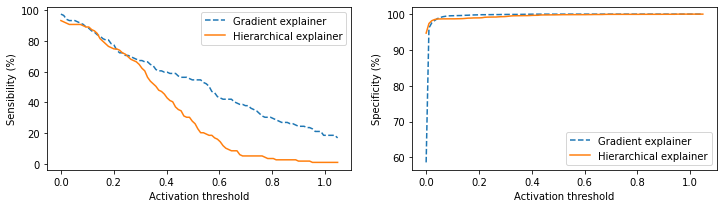

In [99]:
gradientMap = np.sum(shapley_values[0][0], 0)
hierarchicalMap = saliency_map.copy()

upperScoreLimit = np.minimum(np.amax(gradientMap), np.amax(hierarchicalMap))
activationThresholds = np.arange(0, upperScoreLimit, upperScoreLimit / 100)
L = len(activationThresholds)
gradientSes = np.zeros(L)
gradientSps = np.zeros(L)
hierarchicalSes = np.zeros(L)
hierarchicalSps = np.zeros(L)

for i in np.arange(L):
  activationThreshold = activationThresholds[i]

  # INITIALIZE COMPLETE SALIENCY MAPS
  gradientMap = np.sum(shapley_values[0][0], 0)
  hierarchicalMap = saliency_map.copy()

  # REMOVE PIXELS BELOW ACTIVATION THRESHOLD
  gradientMap[np.where(gradientMap < activationThreshold)] = 0
  hierarchicalMap[np.where(hierarchicalMap < activationThreshold)] = 0
  # HIGHLIGHT POSITIVELY MARKED PIXELS
  gradientMap[np.where(gradientMap > activationThreshold)] = 1
  hierarchicalMap[np.where(hierarchicalMap > activationThreshold)] = 1 

  # EVALUATE SENSIBILITY
  totalPositives = np.sum(truthMap)
  gradientSe = np.sum(gradientMap[np.where(truthMap == 1)]) / totalPositives
  hierarchicalSe = np.sum(hierarchicalMap[np.where(truthMap == 1)]) / totalPositives

  # EVALUATE SPECIFICITY VIA FALSE ALLARM: SP = 1 - FA
  totalNegatives = 100*120 - totalPositives
  gradientSp = 1 - np.sum(gradientMap[np.where(truthMap == 0)]) / totalNegatives
  hierarchicalSp = 1 - np.sum(hierarchicalMap[np.where(truthMap == 0)]) / totalNegatives

  # SAVE VALUES
  gradientSes[i] = gradientSe
  gradientSps[i] = gradientSp
  hierarchicalSes[i] = hierarchicalSe
  hierarchicalSps[i] = hierarchicalSp

fig = plt.figure(figsize=(12, 3))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(activationThresholds, gradientSes * 100, '--', label = 'Gradient explainer')
ax1.plot(activationThresholds, hierarchicalSes * 100 , '-', label = 'Hierarchical explainer')
ax1.set_xlabel('Activation threshold')
ax1.set_ylabel('Sensibility (%)')
ax1.legend()
ax2.plot(activationThresholds, gradientSps * 100, '--', label = 'Gradient explainer')
ax2.plot(activationThresholds, hierarchicalSps * 100, '-', label = 'Hierarchical explainer')
ax2.set_xlabel('Activation threshold')
ax2.set_ylabel('Specificity (%)')
ax2.legend()

In [82]:
# EVALUATE ORIGINAL MODEL output
output = model(input).detach().numpy()
exactPrediction = output[0][label]
print('\nEXACT PREDICTION = %.3f' % (exactPrediction))

sizes = np.array([[50, 50], [20,20], [10,10], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1]])
L = len(sizes)

# INITIALIZE SHAP GRADIENT EXPLAINER
gradexp = shap.GradientExplainer(model, X)
nsamples = 200
nruns = 10
gradPredictions = np.zeros(nruns)

for i in np.arange(nruns):
  t0 = time.time()
  shapley_values, indexes = gradexp.shap_values(input, ranked_outputs=2, nsamples=nsamples)
  tf = time.time()
  gradPrediction = np.sum(shapley_values[0])
  gradPredictions[i] = gradPrediction
  print('\nGradient Explainer:\nExecution completed in %.3f ms\nPREDICTION = %.3f' % ((tf - t0)*1e3, gradPrediction))
  #shapley_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shapley_values]
  #image = image[np.newaxis, :]
  #shap.image_plot(shapley_values, image, indexes.numpy(), show=False)

# INITIALIZE SHAP DEEP EXPLAINER
deepexp = shap.DeepExplainer(model, X)

# HIERARCHICAL SHAP
# EXPLAIN IMAGE 1 (with correct label)
hierarchicalPredictions = np.zeros(L)

for i in np.arange(L):
  t0 = time.time()
  print("\nHierarchical Explainer:\nSTARTED EXPLAINING IMAGE 1 @", t0, "s")
  threshold = np.NINF
  size = sizes[i]
  minW = size[0]
  minH = size[1]
  saliency_map, flatnodes = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
  tf = time.time()
  hierarchicalPrediction = np.sum(saliency_map)
  hierarchicalPredictions[i] = hierarchicalPrediction
  computed = explainer.computed
  rejected = explainer.rejected
  print('PREDICTION = %.3f' % hierarchicalPrediction)
  print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
  print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))


EXACT PREDICTION = 73.542

Gradient Explainer:
Execution completed in 1802.461 ms
PREDICTION = 65.516

Gradient Explainer:
Execution completed in 1814.761 ms
PREDICTION = 64.299

Gradient Explainer:
Execution completed in 1791.430 ms
PREDICTION = 66.515

Gradient Explainer:
Execution completed in 1832.982 ms
PREDICTION = 64.760

Gradient Explainer:
Execution completed in 1788.556 ms
PREDICTION = 65.938

Gradient Explainer:
Execution completed in 1816.659 ms
PREDICTION = 66.143

Gradient Explainer:
Execution completed in 1802.800 ms
PREDICTION = 64.832

Gradient Explainer:
Execution completed in 1799.529 ms
PREDICTION = 65.996

Gradient Explainer:
Execution completed in 1797.457 ms
PREDICTION = 66.494

Gradient Explainer:
Execution completed in 1799.550 ms
PREDICTION = 67.161

Hierarchical Explainer:
STARTED EXPLAINING IMAGE 1 @ 1597144483.2445154 s
PREDICTION = 88.777
Computed 4 features out of 12000 pixels (0.03 %) in 36.070 ms -> 9.018 ms per feature
Rejected 0 features (0.00 %) @ t

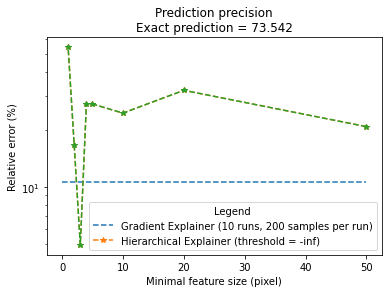

In [83]:
# COMPARE RESULTS
gradientError = np.absolute((exactPrediction - gradPredictions.mean()) / exactPrediction) * 100
hierarchicalError = np.absolute((exactPrediction - hierarchicalPredictions) / exactPrediction) * 100



fig = plt.figure()
ax = fig.subplots()
gradientl = ax.plot([0, sizes[0][0]], [gradientError, gradientError], '--')[0]
hierarchicall = ax.plot(sizes, hierarchicalError, '*--')[0]
ax.set_yscale('log')
ax.set_xlabel('Minimal feature size (pixel)')
ax.set_ylabel('Relative error (%)')
ax.set_title('Prediction precision\nExact prediction = %.3f' % exactPrediction)
lines = [gradientl, hierarchicall]
labels = ['Gradient Explainer (%d runs, %d samples per run)' % (nruns, nsamples), 'Hierarchical Explainer (threshold = %.3f)' % np.NINF]
ax.legend(lines, labels, title = 'Legend')